# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in the audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Python bindings of the Essentia library [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html). Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [40]:
import pandas as pd
import numpy as np
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [41]:
# object to use for label encoding string features
keys_and_scales = {
    "scale": {
        "major": 0,
        "minor": 1
    },
    "key": {
        "C": 0,
        "C#": 1,
        "Db": 1,
        "D": 2,
        "D#": 3,
        "Eb": 3,
        "E": 4,
        "F": 5,
        "F#": 6,
        "Gb": 6,
        "G": 7,
        "G#": 8,
        "Ab": 8,
        "A": 9,
        "A#": 10,
        "Bb": 10,
        "B": 11
    }
}


In [42]:
# Sound analysis function

def analyze_sound(audio_path, beat_positions, audio_id=None):
    
    analysis_output = []  # store the analysis results for each chunk (frame) of the audio file
    
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    
    frame_start_samples = beat_positions
    frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])
    
    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):
        # Get corresponding audio chunk and initialize dictionary to store analysis results with some basic metadata
        if (fend-fstart) % 2 != 0:
            fend -= 1
        if fend > len(audio):
            break
        else: 
            frame = audio[fstart:fend]
        
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # adding key, scale, and key_strength
        key_algo = estd.KeyExtractor()
        key, scale, key_strength = key_algo(frame)
        
        # adding ZCR
        zero_crossing_algo = estd.ZeroCrossingRate()
        zero_crossing_rate = zero_crossing_algo(frame)
        
        # adding fundamental frequency melody
        f0_algo = estd.PitchMelodia()
        f0, f0_confidence = f0_algo(frame)
        
        frame_output['key'] = keys_and_scales['key'][key]
        frame_output['scale'] = keys_and_scales['scale'][scale]
        frame_output['key_strength'] = key_strength
        frame_output['zero_crossing_rate'] = zero_crossing_rate
        frame_output['f0'] = np.median(f0)
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)
    return analysis_output

## Analyze the target sound file

Analyzing target sound StarWars.mp3


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Saved target dataframe with 48 entries! dataframe_target.csv


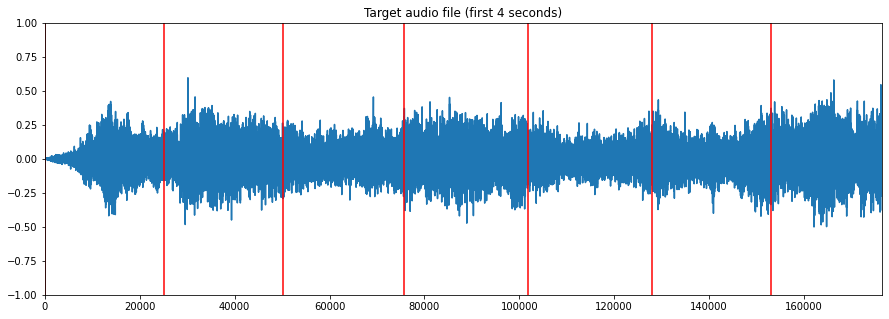

,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,key,scale,key_strength,zero_crossing_rate,f0
0,StarWars.mp3,StarWars.mp3_f0,StarWars.mp3,0,25088,0.001301,-726.390137,84.421310,-47.878227,0.513252,...,-12.563166,-2.214720,-9.893961,-3.756830,-1.021458,3,0,0.757040,0.075375,468.870148
1,StarWars.mp3,StarWars.mp3_f1,StarWars.mp3,25088,50176,0.002197,-687.958496,129.355606,-17.878117,19.507851,...,-8.462265,-3.604931,-5.267977,-6.145575,-6.626438,10,1,0.732705,0.057717,180.773148
2,StarWars.mp3,StarWars.mp3_f2,StarWars.mp3,50176,75776,0.001370,-721.688293,101.032295,-28.532017,7.471331,...,-1.441986,2.373087,-4.251038,-6.851311,-9.168516,10,0,0.824114,0.077852,702.513123
3,StarWars.mp3,StarWars.mp3_f3,StarWars.mp3,75776,101888,0.002091,-695.761719,120.408569,-19.413345,21.755243,...,-3.558990,2.744471,-7.974436,-9.770330,-10.883657,10,0,0.805400,0.066521,706.582825
4,StarWars.mp3,StarWars.mp3_f4,StarWars.mp3,101888,128000,0.001186,-741.155273,102.541351,-33.722099,13.257011,...,4.087433,-2.318035,-6.951166,-1.820547,-5.810173,10,0,0.790263,0.078699,0.000000
5,StarWars.mp3,StarWars.mp3_f5,StarWars.mp3,128000,153088,0.001587,-723.269287,97.292892,-29.840130,1.993181,...,-0.874926,-0.499138,-9.436892,-3.057983,-6.455187,10,0,0.831248,0.083984,937.744202
6,StarWars.mp3,StarWars.mp3_f6,StarWars.mp3,153088,178688,0.002338,-670.867859,111.909531,-15.908854,15.348610,...,-0.940134,-5.121550,-9.769369,-12.879391,-7.133192,10,1,0.856701,0.076758,937.744202
7,StarWars.mp3,StarWars.mp3_f7,StarWars.mp3,178688,204288,0.002249,-677.575073,114.480904,-13.360867,17.557590,...,3.619265,-0.947031,-6.435783,-6.665331,-2.032061,10,1,0.869476,0.067148,702.513123
8,StarWars.mp3,StarWars.mp3_f8,StarWars.mp3,204288,229888,0.001655,-718.041870,114.093781,-21.850370,9.495544,...,2.159122,-8.073105,-3.999866,-1.580172,-5.849039,10,0,0.938343,0.078047,468.870148
9,StarWars.mp3,StarWars.mp3_f9,StarWars.mp3,229888,256000,0.001702,-713.542358,92.996933,-20.851589,12.788824,...,-0.076988,-5.236872,-8.267399,-1.919748,-8.311586,10,1,0.820722,0.090533,937.744202


,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,key,scale,key_strength,zero_crossing_rate,f0
count,4.800000e+01,4.800000e+01,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,5.981227e+05,6.230507e+05,0.001801,-722.638855,130.379929,-25.989687,12.128663,-8.318230,-5.531870,-7.616923,...,-5.145510,-2.037344,-4.970086,-3.939423,-2.180773,6.208333,0.208333,0.819079,0.063137,445.054840
std,3.521999e+05,3.513086e+05,0.000617,34.266518,18.487988,9.051200,6.111677,4.979736,6.641109,6.528088,...,5.713493,5.006386,4.216441,6.063417,7.644920,3.093977,0.410414,0.079222,0.011196,283.293518
min,0.000000e+00,2.508800e+04,0.000805,-798.276306,84.421310,-47.878227,0.513252,-23.090649,-23.333683,-25.346954,...,-16.645622,-13.978577,-12.527256,-16.339462,-13.920929,2.000000,0.000000,0.551860,0.039402,0.000000
25%,3.011840e+05,3.276800e+05,0.001260,-744.270264,118.059877,-32.815196,7.371819,-11.952720,-8.019220,-11.713341,...,-8.919745,-5.150380,-8.047677,-6.989567,-6.635169,3.000000,0.000000,0.786066,0.055866,223.061882
50%,6.049280e+05,6.300160e+05,0.001795,-718.845154,132.923492,-26.743396,12.689974,-7.572696,-4.985575,-7.535348,...,-5.256072,-1.618321,-5.124678,-4.288171,-4.668781,5.000000,0.000000,0.829450,0.064517,451.684769
75%,8.961280e+05,9.212160e+05,0.002195,-702.344742,141.772396,-19.086510,17.579846,-5.354291,-1.283523,-2.224669,...,-1.316523,2.169185,-2.488022,-1.460601,-0.237471,10.000000,0.000000,0.870006,0.071057,699.478470
max,1.174016e+06,1.196544e+06,0.004047,-634.856201,166.675797,-5.392796,21.755243,1.113861,6.122690,6.225449,...,7.874893,6.743343,8.149384,11.958817,22.891754,10.000000,1.000000,0.938343,0.090533,1040.492920


In [43]:
TARGET_SOUND_PATH = 'StarWars.mp3'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

loader = estd.MonoLoader(filename=TARGET_SOUND_PATH)
audio = loader()
beat_tracker_algo = estd.BeatTrackerDegara()
beat_positions = beat_tracker_algo(audio)
beat_positions = [int(round(position * 44100)) for position in beat_positions]
beat_positions.insert(0, 0)

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
target_analysis = analyze_sound(TARGET_SOUND_PATH, beat_positions, audio_id=TARGET_SOUND_PATH.split('__')[0])
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))


# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

## Analyze source collection

In [44]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of the analysis

# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    analysis_output = analyze_sound(sound['path'], beat_positions, audio_id=sound['freesound_id'])  # Split audio in chunks of 200ms (44100/5 samples)
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 115591 [1/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 78674 [2/60]
Analyzing sound with id 517746 [3/60]
Analyzing sound with id 557194 [4/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 650564 [5/60]
Analyzing sound with id 47126 [6/60]
Analyzing sound with id 47123 [7/60]
Analyzing sound with id 47124 [8/60]
Analyzing sound with id 47127 [9/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[ WARNING  ] AudioLoader: Error reading frame: Invalid data found when processing input
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[ WARNING  ] AudioLoader: Error reading frame: Invalid data found when processing input
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" paramet

Analyzing sound with id 47125 [10/60]
Analyzing sound with id 571423 [11/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 537212 [12/60]


[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 537217 [13/60]


[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13313) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13313) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 540214 [14/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 166532 [15/60]
Analyzing sound with id 619968 [16/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 520027 [17/60]
Analyzing sound with id 591432 [18/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 643788 [19/60]
Analyzing sound with id 644818 [20/60]
Analyzing sound with id 612875 [21/60]


[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 500546 [22/60]
Analyzing sound with id 657941 [23/60]
Analyzing sound with id 665822 [24/60]


[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 660110 [25/60]
Analyzing sound with id 657940 [26/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 470903 [27/60]


[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 376694 [28/60]
Analyzing sound with id 190707 [29/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 128349 [30/60]
Analyzing sound with id 397280 [31/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 482231 [32/60]
Analyzing sound with id 77172 [33/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 337112 [34/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12289) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 151015 [35/60]
Analyzing sound with id 42106 [36/60]
Analyzing sound with id 72639 [37/60]
Analyzing sound with id 344513 [38/60]
Analyzing sound with id 572278 [39/60]
Analyzing sound with id 66807 [40/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 339102 [41/60]
Analyzing sound with id 92898 [42/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 584917 [43/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 404759 [44/60]
Analyzing sound with id 256543 [45/60]
Analyzing sound with id 165828 [46/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 127014 [47/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 412799 [48/60]
Analyzing sound with id 412800 [49/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 199905 [50/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 554411 [51/60]
Analyzing sound with id 146304 [52/60]
Analyzing sound with id 166608 [53/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 159429 [54/60]
Analyzing sound with id 362373 [55/60]


[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 138383 [56/60]


[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 126286 [57/60]


[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 390531 [58/60]


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (13057) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filte

Analyzing sound with id 442255 [59/60]
Analyzing sound with id 81514 [60/60]
Saved source DataFrame with 503 entries! dataframe_source.csv


[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12545) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] TriangularBands: input spectrum size (12801) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


,freesound_id,id,path,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,key,scale,key_strength,zero_crossing_rate,f0
0,115591,115591_f0,files/115591_1015240-hq.ogg,0,25088,0.003325,-731.489136,-54.322849,5.227661,67.991081,...,-15.090132,9.040024,-5.469172,2.457767,-8.771339,0,0,0.483390,0.103037,0.000000
1,115591,115591_f1,files/115591_1015240-hq.ogg,25088,50176,0.005537,-620.853760,43.180622,-34.844627,96.652863,...,-14.203045,-0.069721,-15.470999,-5.086895,-15.287912,0,1,0.647957,0.151706,1154.499878
2,115591,115591_f2,files/115591_1015240-hq.ogg,50176,75776,0.001865,-812.981384,145.029282,-66.712906,69.713898,...,15.047474,19.995121,-1.599598,19.014826,3.156548,3,1,0.747373,0.031562,75.132347
3,115591,115591_f3,files/115591_1015240-hq.ogg,75776,101888,0.000159,-1117.504517,92.750305,26.325481,38.148827,...,17.880295,19.036268,8.921379,12.494942,10.573277,3,1,0.535157,0.017042,74.699623
4,115591,115591_f4,files/115591_1015240-hq.ogg,101888,128000,0.000228,-1120.535645,164.452576,76.858597,1.669159,...,-15.195518,0.822788,13.501450,19.297771,19.539314,9,1,0.774508,0.003906,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,390531,390531_f15,files/390531_7139941-hq.ogg,387072,413696,0.001094,-777.426392,114.651497,-16.761108,30.563976,...,-18.225136,-1.388355,-19.732162,-17.514462,-9.052158,5,0,0.723354,0.202449,0.000000
499,390531,390531_f16,files/390531_7139941-hq.ogg,413696,439808,0.000740,-805.581787,98.359665,-24.942734,9.036575,...,10.437906,-29.267195,6.681452,12.367790,-9.038918,0,0,0.889912,0.288603,0.000000
500,81514,81514_f0,files/81514_450294-hq.ogg,0,25088,0.000004,-1183.991821,42.347721,-20.539497,3.986313,...,10.449169,14.975155,10.724876,5.328350,-3.839684,8,0,0.707830,0.134686,640.496704
501,81514,81514_f1,files/81514_450294-hq.ogg,25088,50176,0.000266,-983.681213,171.114716,17.200249,22.541409,...,-5.463478,-9.542778,7.785690,30.032101,-28.714560,0,0,0.717548,0.074458,0.000000


,freesound_id,start_sample,end_sample,loudness,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,key,scale,key_strength,zero_crossing_rate,f0
count,503.000000,5.030000e+02,5.030000e+02,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,...,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,325894.302187,2.677587e+05,2.932610e+05,0.003792,-928.942810,84.964638,-12.747891,10.093294,-4.816261,7.565187,...,-1.508399,2.850831,0.382974,-0.849399,2.124792,5.282306,0.596421,0.526875,0.089012,301.396820
std,212210.624701,2.754216e+05,2.750809e+05,0.004904,204.270096,105.125687,66.240440,45.621071,38.252781,30.258959,...,21.972387,18.082314,17.253633,13.821270,12.692782,3.353036,0.491103,0.426680,0.105071,475.365448
min,47123.000000,0.000000e+00,2.508800e+04,0.000000,-1264.911621,-205.197189,-232.471130,-148.309006,-176.473785,-121.265068,...,-119.919220,-107.967438,-74.301224,-53.243660,-37.052074,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,128349.000000,5.017600e+04,7.577600e+04,0.000217,-1083.355835,12.323491,-49.822954,-9.736856,-26.881093,-7.496149,...,-8.412526,-3.646940,-6.966393,-6.727352,-5.195713,3.000000,0.000000,0.480578,0.015397,0.000000
50%,337112.000000,1.786880e+05,2.042880e+05,0.001666,-940.411438,96.094154,-0.000069,15.391603,-0.000080,8.728752,...,-0.000050,4.685406,2.552933,0.589729,1.348503,5.000000,1.000000,0.623382,0.044045,0.000000
75%,537217.000000,3.870720e+05,4.136960e+05,0.004649,-751.799194,164.016769,19.171479,38.519905,18.317253,25.468492,...,8.557957,11.531594,9.449690,7.420807,11.529083,8.000000,1.000000,0.747081,0.137626,475.692047
max,665822.000000,1.174016e+06,1.196544e+06,0.020273,-481.434601,302.587463,138.347473,148.029434,88.171700,112.742332,...,72.817337,83.636017,102.437996,48.328346,59.263489,11.000000,1.000000,0.938287,0.756016,1749.898926
